In [1]:
import numpy as np # import numpy library as np
import matplotlib.pyplot as plt # import pyplot library as plt 
import matplotlib.animation as animation # import animation modules from matplotlib
from   mpl_toolkits.mplot3d import Axes3D # import Axes3D from mpl_toolkits.mplot3d
from   numpy import newaxis # import newaxis used for inter-particle force calculations
from IPython.display import HTML

plt.style.use('ggplot') # use "ggplot" style for graphs

In [2]:
def init():
    global R,V,W,F,Rs,Vs,Ws,time # define global variables
    initconf()          # create random particle configuration without overlaps
    V[:,:] = 0.0        # initialize all the variables to zero
    W[:,:] = 0.0        # initialize all the variables to zero
    F[:,:] = 0.0        # initialize all the variables to zero
    Rs[:,:,:] = 0.0     # initialize all the variables to zero
    Rs[0,:,:] = R[:,:]  # store initial particle positions in Rs
    Vs[:,:,:] = 0.0     # initialize all the variables to zero
    Ws[:,:,:] = 0.0     # initialize all the variables to zero
    time[:]   = 0.0     # initialize all the variables to zero
    title.set_text(r'') # empty title
    line.set_data_3d([],[],[]) # set line data to show the trajectory of particle n in 3d (x,y,z)
    particles.set_data_3d([],[],[]) # set position current (x,y,z) position data for all particles
    return particles,title,line # return listed objects that will be drawn by FuncAnimation

In [3]:

def animate(i):
    global R,V,W,F,Rs,Vs,Ws,time # define global variables
    time[i]=i*dt # store time in each step in an array time
    particleforces() # compute inter-particle force F by examining all nump^2 pairs
    W = std*np.random.randn(nump,dim) # generate an array of random forces accordingly
    V = (V*(1-zeta/2/m*dt)+F/m*dt+W/m)/(1+zeta/2/m*dt) # update velocity using the L-F method
    R = R+V*dt # update position via L-F method
    Rs[i,:,:]=R # accumulate particle positions at each step in an array Rs
    Vs[i,:,:]=V # accumulate particle velocitys at each step in an array Vs
    Ws[i,:,:]=W # accumulate random forces at each step in an array Ws
    title.set_text(r"t = "+str(time[i])+"/"+str((nums-1)*dt))  # set the title to display the current time
    line.set_data(Rs[:i+1,n,0],Rs[:i+1,n,1]) # set the line in 2D (x,y)
    line.set_3d_properties(Rs[:i+1,n,2]) # add z axis to set the line in 3D
    particles.set_data(pbc(R[:,0],box[0]), pbc(R[:,1],box[1])) # set the current position of all the particles in 2d (x,y) with PBC
    particles.set_3d_properties(pbc(R[:,2],box[2])) # add z axis to set the particle in 3D with PBC
    return particles,title,line # return listed objects that will be drawn by FuncAnimation

In [4]:
def pbc(r, lbox): # enforce Periodic Boundary Conditions for all positions
    return np.fmod(r+lbox,lbox)
def distance(r1,r2,lbox): # Compute distance vector R2 - R1 with PBC
    return r2-r1-np.around((r2-r1)/lbox)*lbox
def fij(r2,rij): # calculate Fij=dU/drij
#    f=-24*eps*(2*(r2/sig**2)**(-6)-(r2/sig**2)**(-3))/r2*rij # Lennard-Jones potential
    f=-48*eps*((r2/sig**2)**(-6))/r2*rij # soft-core potential
    return f 
def particleforces(): # compute inter-particle force F by examining all nump^2 pairs
    global F
    F[:,:] = 0.0
    for n in range(nump): # repeat below for all particles
        rij = distance(R[n,:], R, box) # distance vectors rij=R_i-R_j for all i (1 <= i <= nump)
        r2  = np.linalg.norm(rij, axis=1)**2 # square distance rij**2
        nei = (r2 < (2.0*sig)**2)  # list neighbor particles of j
        nei[n] = False # ignore self pair (i=j)
        F[n,:] = np.sum(fij(r2[nei, newaxis], rij[nei,:]), axis=0) # total force on particle j
def initconf():  # create random particle configuration without overlapping
    global R,V,W,F,Rs,Vs,Ws,time
    for n in range(nump): # repeat below from n=0 to nump-1
        nn=0 # set overlap true to perform while loop below for the n-th particle 
        while nn == 0: # repeat the loop below while overlap is true (nn==0)
            R[n,:]=np.random.rand(dim)*box # generate a position candidate for n using uniform random number.
            nn = 1 # initialize overlap as false
            for l in range(n): # examine overlap generated positions (from l=0 to n-1)
                rij = distance(R[n,:],R[l,:],box) # calculate distance vector rij=R_l-R_n
                r2  = np.linalg.norm(rij)**2 # calculate the squared distance rij**2
                if r2 < (0.90*sig)**2: # check if the distance is smaller than threshold
                # Yes -> perform below (nn=0) -> repeat while loop, No (nn=1) -> exit while loop
                    nn = 0 # set overlap true 

In [5]:
dim  = 3    # system dimension (x,y,z)
nump = 100  # number of interacting Brownian particles to simulate 
nums = 4096 # number of simulation steps
dt   = 0.01 # set time increment, \Delta t
zeta = 1.0  # set friction constant, \zeta
m    = 1.0  # set particle mass, m
kBT  = 1.0  # set thermal energy, k_B T
std  = np.sqrt(2*kBT*zeta*dt) # calculate std 
sig  = 1.0  # unit of length of inter-particle potential
eps  = 1.0  # unit of energy inter-particle potential
vf   = 0.001 ##volume fraction of particles < 0.45 
boxl = np.power(nump*np.pi/6/vf,1/3) # calculate the side length of unit cell
print('Volume fraction =',vf,'  boxl =',boxl) # print vf and boxl
box  = np.array([boxl,boxl,boxl])*sig # set array box[dim]
np.random.seed(0) # initialize random number generator with a seed=0
R = np.zeros([nump,dim]) # array to store current positions and set initial condition 
V = np.zeros([nump,dim]) # array to store current velocities and set initial condition 
W = np.zeros([nump,dim]) # array to store current random forcces
F = np.zeros([nump,dim]) # rray to store current particle orcces
Rs = np.zeros([nums,nump,dim]) # array to store positions at all steps
Vs = np.zeros([nums,nump,dim]) # array to store velocities at all steps
Ws = np.zeros([nums,nump,dim]) # array to store random forces at all steps
time = np.zeros([nums]) # an array to store time at all steps

Volume fraction = 0.001   boxl = 37.41101926818244


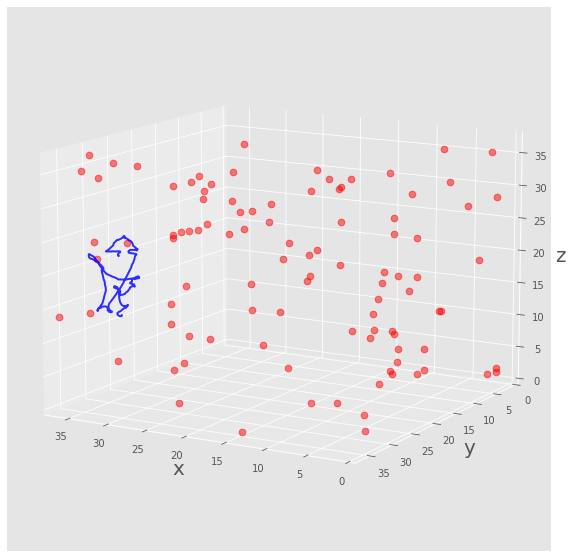

In [6]:
fig1 = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax1 = fig1.add_subplot(111,projection='3d') # creates an additional axis to the standard 2D axes
ax1.set_xlim(0.0,box[0]) # set x-range
ax1.set_ylim(0.0,box[1]) # set y-range
ax1.set_zlim(0.0,box[2]) # set z-range
ax1.set_xlabel(r"x",fontsize=20) # set x-lavel
ax1.set_ylabel(r"y",fontsize=20) # set y-lavel
ax1.set_zlabel(r"z",fontsize=20) # set z-lavel
ax1.view_init(elev=12,azim=120)  # set view point
particles, = ax1.plot([],[],[],linestyle='None',color='r',marker='o',ms=250/box[0],alpha=0.5) # define object particles
title = ax1.text(0.,0.,0.,r'',transform=ax1.transAxes,va='center') # define object title
line, = ax1.plot([],[],[],'b',lw=2,alpha=0.8) # define object line
n = 0  # trajectry line is plotted for the n-th particle
anim = animation.FuncAnimation(fig1,func=animate,init_func=init,
            frames=nums,interval=5,blit=True,repeat=False)

HTML(anim.to_html5_video()) # HTML5 Video

D_0 = 1.0 (Theoretical)
D = 0.8714350790269677 (Simulation via MSD)
Volume fraction = 0.001


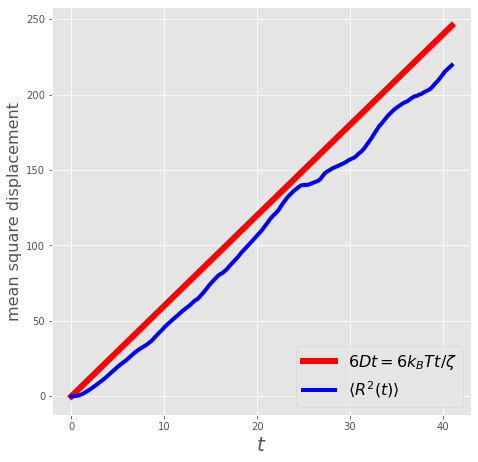

In [7]:
# mean square displacement vs time
msd = np.zeros([nums])
for i in range(nums):
    for n in range(nump):
        msd[i]=msd[i]+np.linalg.norm(Rs[i,n,:]-Rs[0,n,:])**2 # (R(t) - R(0))^2
    msd[i] = msd[i]/nump
dmsd = np.trapz(msd, dx=dt)/(3*(nums*dt)**2)
print('D_0 =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')
print('Volume fraction =',vf) ### print vf
fig2, ax2 = plt.subplots(figsize=(7.5,7.5))
ax2.set_xlabel(r"$t$", fontsize=20)
ax2.set_ylabel(r"mean square displacement", fontsize=16)
ax2.plot(time,6*kBT/zeta*time,'r',lw=6,label=r'$6Dt={6k_BT t}/{\zeta}$')
ax2.plot(time,msd,'b',lw=4, label=r'$\langle R^2(t)\rangle$')
ax2.legend(fontsize=16, loc=4)


plt.show()